In [3]:
import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np

from time import time

# to plot pretty histograms
import seaborn as sns
import pandas as pd

from sde.sde_learning_network import \
    (
        SDEIdentification,
        ModelBuilder,
        SDEApproximationNetwork,
    )

from sde.experiment_reports import \
(
    sample_data,
    plot_results_functions,
    generate_results,
    plot_results_1d,
    probability_density
)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# notebook parameters
random_seed = 1
step_size = 1e-2  # step size
n_pts = 10000        # number of points

n_layers = 2
n_dim_per_layer = 50

ACTIVATIONS = tf.nn.elu
VALIDATION_SPLIT = .1
BATCH_SIZE = 32
N_EPOCHS = 250

xlim = [-2, 2]

# only diagonal, but we are in 1D so it does not matter anyway
diffusivity_type = "diagonal"

tf.random.set_seed(random_seed)

In [5]:
# EXAMPLE 1
def true_drift(x):
    return -(4*x**3 - 2*4*x+3)/2 # negative derivative of the potential

def true_diffusivity(x):
    return (1e-1*x+1)*0.5

def true_drift_diffusivity(x):
    return true_drift(x), true_diffusivity(x)

def sample_nd_data(n_dimensions, _rng, print_results=False, increase_n_points=False):
    if increase_n_points:
        _n_pts = n_pts * n_dimensions
    else:
        _n_pts = n_pts
    x_data, y_data = sample_data(true_drift_diffusivity,
                                 step_size=step_size, n_dimensions=n_dimensions,
                                 low=xlim[0], high=xlim[1], n_pts=_n_pts,
                                 rng=_rng)
    if print_results:
        print('data shape', x_data.shape)

    step_sizes = np.zeros((x_data.shape[0],)) + step_size
    return x_data, y_data, step_sizes

In [6]:
# define the neural network model we will use for identification
def define_nd_model(n_dimensions):
    encoder = ModelBuilder.define_gaussian_process(
                                            n_input_dimensions=n_dimensions,
                                            n_output_dimensions=n_dimensions,
                                            n_layers=n_layers,
                                            n_dim_per_layer=n_dim_per_layer,
                                            name="GP",
                                            activation=ACTIVATIONS,
                                            diffusivity_type=diffusivity_type)
    model = SDEApproximationNetwork(sde_model=encoder, method="euler")
    model.compile(optimizer=tf.keras.optimizers.Adamax())

    sde_i = SDEIdentification(model=model)
    
    return sde_i

In [13]:
def train_nd_model(n_dimensions, x_data_nd, y_data_nd, step_sizes_nd, sde_i, plot_history=False):
    hist = sde_i.train_model(x_data_nd, y_data_nd, step_size=step_sizes_nd,
                                 validation_split=VALIDATION_SPLIT, n_epochs=N_EPOCHS//n_dimensions, batch_size=BATCH_SIZE)

    if plot_history:
        fig, hist_axes = plt.subplots(1, 1, figsize=(10, 5))
        hist_axes.clear()
        hist_axes.plot(hist.history["loss"], label='loss')
        hist_axes.plot(hist.history["val_loss"], label='validation')
        hist_axes.legend()
        
        print(f"Training loss at ndim={n_dimensions}: {hist.history['loss'][-1]}")
        print(f"Validation loss at ndim={n_dimensions}: {hist.history['val_loss'][-1]}")
    
    return dict(loss=hist.history['loss'][-1], val_loss=hist.history['val_loss'][-1])

In [14]:
def evaluate_nd_model(n_dimensions, rng, print_results=False, increase_n_points=False):
    t0=time()
    x_data_nd, y_data_nd, step_sizes_nd = sample_nd_data(n_dimensions,
                                                         _rng=rng,
                                                         increase_n_points=increase_n_points)
    t1=time()
    sde_i_nd = define_nd_model(n_dimensions)
    t2=time()
    result_nd = train_nd_model(n_dimensions, x_data_nd, y_data_nd, step_sizes_nd, sde_i_nd, plot_history=print_results)
    t3=time()
    return result_nd, dict(time_sample=t1-t0, time_define=t2-t1, time_train=t3-t2), sde_i_nd

In [15]:
def results_to_dataframe(_loss, _time):
    df = pd.DataFrame(columns=["n_dimensions",
                               "n_iteration",
                               "loss",
                               "val_loss",
                               "time_sample",
                               "time_define",
                               "time_train"])
    for k in range(len(_loss)):
        dict_row = dict()
        loss_correction = 2*np.log(2*np.pi)/np.log(10)*_time[k]["n_dimensions"]
        dict_row["n_dimensions"] = _time[k]["n_dimensions"]
        dict_row["n_iteration"] = _time[k]["n_iteration"]
        dict_row["loss"] = _loss[k]["loss"] + loss_correction
        dict_row["val_loss"] = _loss[k]["val_loss"] + loss_correction
        dict_row["time_sample"] = _time[k]["time_sample"]
        dict_row["time_define"] = _time[k]["time_define"]
        dict_row["time_train"] = _time[k]["time_train"]
        df.loc[k] = dict_row
    return df



training for 41 epochs with 54000 data points, validating with 6000
The average loss for epoch 40 is -9.5779831657 Training loss at ndim=6: -9.57798316566295
Validation loss at ndim=6: -9.572487497244568


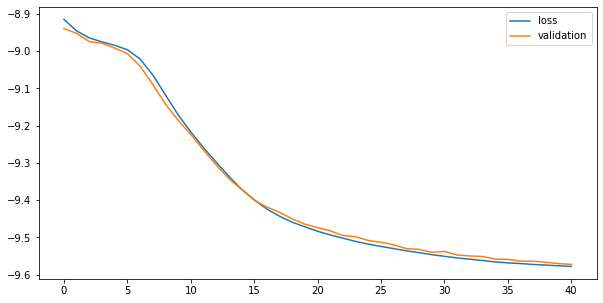

In [16]:
# run once to see if everything works as it should
rng = np.random.default_rng(random_seed)
result_loss, result_time, sde_i_model = evaluate_nd_model(n_dimensions=6,
                                                          rng=rng,
                                                          print_results=True,
                                                          increase_n_points=True)

In [56]:
# now run over multiple dimensions, multiple times
results_loss = []
results_time = []

n_iterations = 10  # iterations per dimension
for n_dimensions in np.arange(1, 20, 1):
    for n_iteration in np.arange(0, n_iterations):
        rng = np.random.default_rng(n_iteration+random_seed)

        result_loss, result_time, _ = evaluate_nd_model(n_dimensions=n_dimensions,
                                                        print_results=False,
                                                        rng=rng,
                                                        increase_n_points=False)
        result_time["n_iteration"] = n_iteration
        result_time["n_dimensions"] = n_dimensions
        results_loss.append(result_loss)
        results_time.append(result_time)

training for 250 epochs with 9000 data points, validating with 1000
The average loss for epoch 249 is -1.5983028982 training for 250 epochs with 9000 data points, validating with 1000
The average loss for epoch 249 is -1.6143894425 training for 250 epochs with 9000 data points, validating with 1000
The average loss for epoch 249 is -1.6066356001 training for 250 epochs with 9000 data points, validating with 1000
The average loss for epoch 249 is -1.5937487959 training for 250 epochs with 9000 data points, validating with 1000
The average loss for epoch 249 is -1.6148811746 training for 250 epochs with 9000 data points, validating with 1000
The average loss for epoch 249 is -1.6119679779 training for 250 epochs with 9000 data points, validating with 1000
The average loss for epoch 249 is -1.6005153774 training for 250 epochs with 9000 data points, validating with 1000
The average loss for epoch 249 is -1.5921459950 training for 250 epochs with 9000 data points, validating with 1000
The 

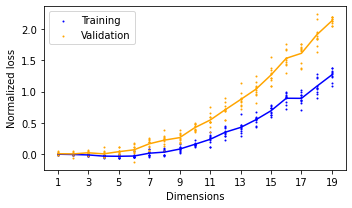

In [87]:

df = results_to_dataframe(results_loss, results_time)
df.to_csv('figures/fullrun_n_iteration10_n_dimensions_1to20.csv')

data_mean = [np.mean(k["loss"]) for (_,k) in df.groupby("n_dimensions")]
data_std = [np.mean(k["loss"]) for (_,k) in df.groupby("n_dimensions")]
data_mean_val = [np.mean(k["val_loss"]) for (_,k) in df.groupby("n_dimensions")]
data_std_val = [np.mean(k["val_loss"]) for (_,k) in df.groupby("n_dimensions")]
data_idx = np.arange(1, len(data_mean)+1)

fig, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.scatter(df["n_dimensions"], df["loss"], s=1,color="blue", label="Training")
ax.scatter(df["n_dimensions"], df["val_loss"], s=1, color="orange", label="Validation")
ax.plot(data_idx, data_mean, color="blue")
ax.plot(data_idx, data_mean_val, color="orange")
ax.set_xticks(np.arange(1, 20, 2));
ax.set_xlabel("Dimensions")
ax.set_ylabel("Normalized loss")
ax.legend()
fig.tight_layout()

fig.savefig("figures/fullrun_n_iteration10_n_dimensions_1to20.pdf")
fig.savefig("figures/fullrun_n_iteration10_n_dimensions_1to20.png")

In [16]:
print(2*np.log(2*np.pi)/np.log(10)*7)

11.174518157013608


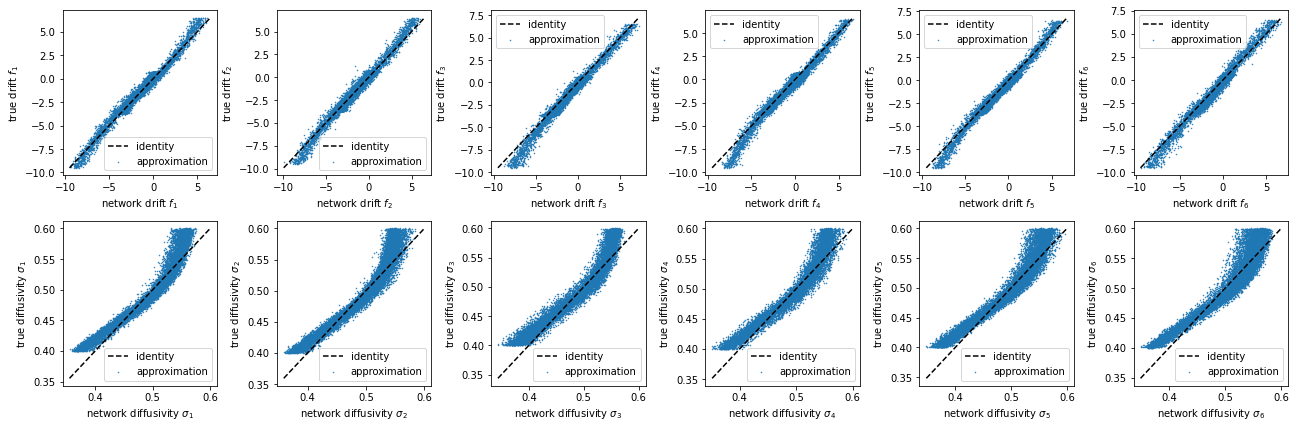

In [17]:
rng = np.random.default_rng(random_seed)

x_data_nd, y_data_nd, step_sizes_nd = sample_nd_data(n_dimensions=6, _rng=rng)
ax = plot_results_functions(sde_i_model.drift_diffusivity, true_drift_diffusivity,
                            x_data_nd, y_data_nd, rng,
                            data_transform_network=None,
                            data_transform_true=None)

In [ ]:
# now, try the same but with an increasing number of points
results_loss2 = []
results_time2 = []

n_iterations = 1  # iterations per dimension
for n_dimensions in np.arange(1, 20, 5):
    for n_iteration in np.arange(0, n_iterations):
        t0=time()
        rng = np.random.default_rng(n_iteration+random_seed)

        result_loss, result_time, _ = evaluate_nd_model(n_dimensions=n_dimensions,
                                                        print_results=False,
                                                        rng=rng,
                                                        increase_n_points=True)
        print(f"dim={n_dimensions}, iter={n_iteration} took {time()-t0} seconds.")
        result_time["n_iteration"] = n_iteration
        result_time["n_dimensions"] = n_dimensions
        results_loss2.append(result_loss)
        results_time2.append(result_time)

df2 = results_to_dataframe(results_loss2, results_time2)
file2 = 'figures/fullrun_n_iteration10_n_dimensions_1to20_newpoints.csv'
df2.to_csv(file2)

training for 250 epochs with 9000 data points, validating with 1000
The average loss for epoch 249 is -1.5984408614 dim=1, iter=0 took 55.988263845443726 seconds.
training for 41 epochs with 54000 data points, validating with 6000
The average loss for epoch 40 is -9.5640513740 dim=6, iter=0 took 67.12762379646301 seconds.
training for 22 epochs with 99000 data points, validating with 11000
The average loss for epoch 21 is -17.0943544199 dim=11, iter=0 took 75.26033782958984 seconds.


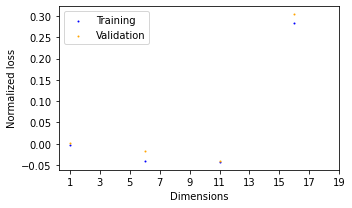

In [11]:
df2 = pd.read_csv(file2)

data_mean = [np.mean(k["loss"]) for (_,k) in df2.groupby("n_dimensions")]
data_std = [np.mean(k["loss"]) for (_,k) in df2.groupby("n_dimensions")]
data_mean_val = [np.mean(k["val_loss"]) for (_,k) in df2.groupby("n_dimensions")]
data_std_val = [np.mean(k["val_loss"]) for (_,k) in df2.groupby("n_dimensions")]
data_idx = np.arange(1, len(data_mean)+1)

fig, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.scatter(df2["n_dimensions"], df2["loss"], s=1,color="blue", label="Training")
ax.scatter(df2["n_dimensions"], df2["val_loss"], s=1, color="orange", label="Validation")
#ax.plot(data_idx, data_mean, color="blue")
#ax.plot(data_idx, data_mean_val, color="orange")
ax.set_xticks(np.arange(1, 20, 2));
ax.set_xlabel("Dimensions")
ax.set_ylabel("Normalized loss")
ax.legend()
fig.tight_layout()

fig.savefig("figures/fullrun_n_iteration10_n_dimensions_1to20_newpoints.pdf")
fig.savefig("figures/fullrun_n_iteration10_n_dimensions_1to20_newpoints.png")